In [327]:
!python -V

Python 3.11.7


### Import packages 

In [328]:
import pandas as pd

# Set the float format to display numbers without scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [329]:
# Package: pickle
# Purpose: This package provides functionality for working with pickle files.
# Pickle is a Python module used for serializing and deserializing Python objects.
# It allows you to save and load Python objects to and from disk, preserving their state.

import pickle

In [330]:
# Package: seaborn
# Purpose: Seaborn is a data visualization library based on Matplotlib.
# It provides a high-level interface for creating informative and attractive statistical graphics.
import seaborn as sns

# Package: matplotlib.pyplot
# Purpose: Matplotlib is a plotting library for creating static, animated, and interactive visualizations in Python. 
# pyplot is a collection of functions that provide a simple interface for creating plots and visualizations.
import matplotlib.pyplot as plt

In [331]:
# Package: DictVectorizer 
# Purpose: Convert a collection of dictionaries into a matrix representation
from sklearn.feature_extraction import DictVectorizer  

# Package: LinearRegression
# Purpose: Implement linear regression models
from sklearn.linear_model import LinearRegression  

# Package: Lasso
# Purpose: Implement Lasso regression models
from sklearn.linear_model import Lasso  

# Package: Ridge
# Purpose: Implement Ridge regression models
from sklearn.linear_model import Ridge  

# Package: mean_squared_error
# Purpose: Calculate the mean squared error between two arrays
from sklearn.metrics import mean_squared_error  

### Download data from URLs

In [332]:
# January 2024 
!wget -P data/ https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet

# February 2024
!wget -P data/ https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet


--2024-05-19 09:33:29--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.164.247.127, 3.164.247.148, 3.164.247.182, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.164.247.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49961641 (48M) [binary/octet-stream]
Saving to: ‘data/yellow_tripdata_2024-01.parquet’

yellow_tripdata_202 100%[===================>]  47.65M   291MB/s    in 0.2s    

2024-05-19 09:33:29 (291 MB/s) - ‘data/yellow_tripdata_2024-01.parquet’ saved [49961641/49961641]

--2024-05-19 09:33:30--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.164.247.127, 3.164.247.182, 3.164.247.101, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.164.247.127|:443... connected.
H

### Read data and display variable types

In [333]:
# Read in the data from the parquet file
df = pd.read_parquet('./data/yellow_tripdata_2024-01.parquet')

# Display the column names and data types of the DataFrame
df_info = pd.DataFrame({'Data Type': df.dtypes})
print(df_info)

                            Data Type
VendorID                        int32
tpep_pickup_datetime   datetime64[us]
tpep_dropoff_datetime  datetime64[us]
passenger_count               float64
trip_distance                 float64
RatecodeID                    float64
store_and_fwd_flag             object
PULocationID                    int32
DOLocationID                    int32
payment_type                    int64
fare_amount                   float64
extra                         float64
mta_tax                       float64
tip_amount                    float64
tolls_amount                  float64
improvement_surcharge         float64
total_amount                  float64
congestion_surcharge          float64
Airport_fee                   float64


### Create duration variable and display standard deviation

In [334]:
# Calculate the duration of the trip in minutes
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

# Convert the duration to minutes
# The total_seconds() method returns the total number of seconds in a timedelta object.
# We divide by 60 to convert seconds to minutes.
# The apply() method applies a function along the length of the DataFrame.
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# Print the standard deviation of the trip duration, concatenated with the string "minutes"
std_duration = df['duration'].std()
print(str(std_duration) + " minutes")


34.851053592192876 minutes


### Plot duration 

<Axes: xlabel='duration', ylabel='Density'>

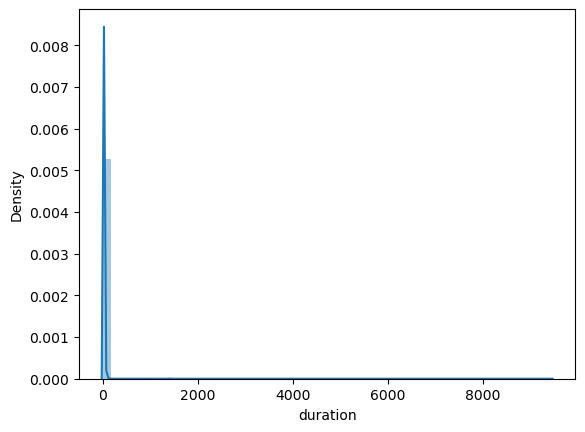

In [335]:
# Remove warning from distplot output
import warnings
warnings.filterwarnings("ignore")

# Plot 
sns.distplot(df['duration'])

### Review percentiles to inform cutoff for filters

In [336]:
df.duration.describe(percentiles = [0.95, 0.98, 0.99])

count   2964624.00
mean         15.61
std          34.85
min         -13.57
50%          11.63
95%          37.93
98%          51.00
99%          60.45
max        9455.40
Name: duration, dtype: float64

### Check % of data contained within filter

In [337]:
# How much data is now included if we filter for >= 1 and <= 60 minutes?
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9778326020432945

### Filter the outliers

In [338]:
# Filter out trips with a duration less than 1 minute or greater than 60 minutes
df = df[(df.duration >= 1) & (df.duration <= 60)]

# Print the standard deviation of the trip duration, concatenated with the string "minutes"
std_duration_post_filter = df['duration'].std()
print(str(std_duration) + " minutes")


34.851053592192876 minutes


### Replot duration after filtering out outliers

<Axes: xlabel='duration', ylabel='Density'>

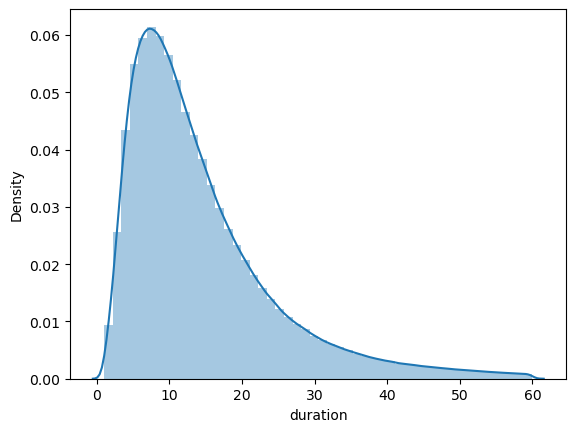

In [339]:
sns.distplot(df['duration'])

### Create feature variables

In [340]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)


## Train a ML model

In [341]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


In [342]:
# Get dimensions of feature matrix
X_train

<2898906x519 sparse matrix of type '<class 'numpy.float64'>'
	with 8696718 stored elements in Compressed Sparse Row format>

In [343]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.952026978464883

### Display predictions vs training values

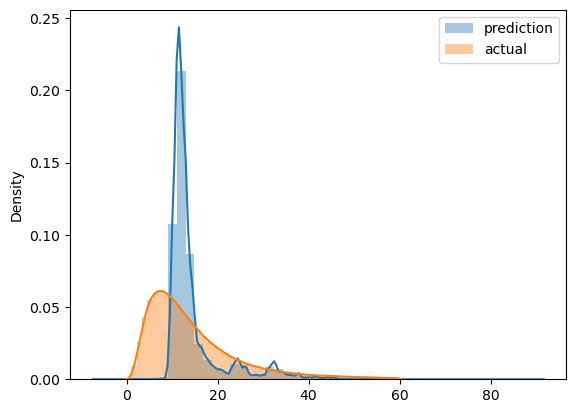

In [344]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

## Test model against validation set 

### Create function to import data and do pre-processing

In [345]:
def read_dataframe (filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df    

### Read data through newly created  pre-processing function 

In [346]:
df_train = read_dataframe('./data/yellow_tripdata_2024-01.parquet')
df_validation = read_dataframe('./data/yellow_tripdata_2024-02.parquet')

len(df_train), len(df_validation)

(2898906, 2938060)

### Add interaction variable

In [347]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_validation['PU_DO'] = df_validation['PULocationID'] + '_' + df_validation['DOLocationID']

### Create training and validation dictionaries and targets

In [348]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_validation[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration' 
y_train = df_train[target].values
y_val = df_validation[target].values


### Linear regression

In [349]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.505711258476828

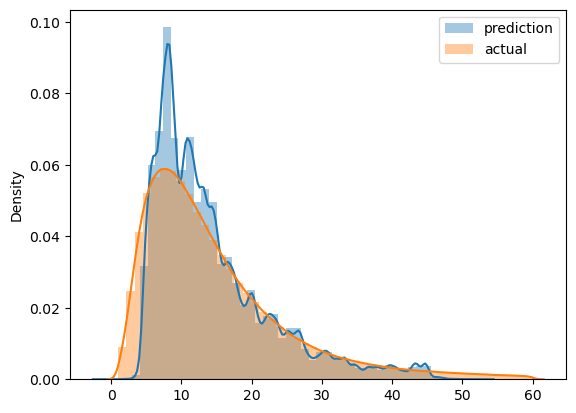

In [350]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

### Lassso

In [351]:
lr = Lasso()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.252110623751554

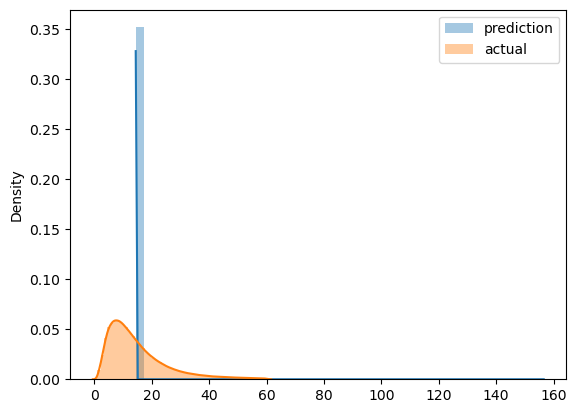

In [352]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

### Ridge 

In [353]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.480475950314928

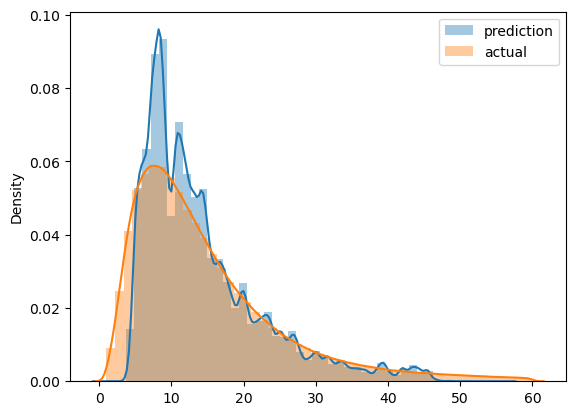

In [354]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

In [355]:
# %reset -f